# Selection Bias - LOO Analysis

This notebook performs Leave-One-Out (LOO) analysis and data attribution for the hierarchical selection bias model. It identifies which score bins have the greatest influence on the model's predictions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import arviz as az
import xarray as xr

from utils import decorate


In [2]:
# Make the figures smaller to save some screen real estate
plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = [6, 3.5]
plt.rcParams["axes.titlelocation"] = "left"

## Load Saved InferenceData

Load the saved InferenceData from the hierarchical model. This allows us to perform LOO analysis without re-running the model.

In [3]:
idata = az.from_netcdf("selection_bias3_idata.nc")

In [4]:
# Verify log-likelihoods are available
print("Available log-likelihood groups:", list(idata.log_likelihood.keys()))
print("obs_bins log-likelihood shape:", idata.log_likelihood['obs_bins'].shape)

Available log-likelihood groups: ['obs_bins']
obs_bins log-likelihood shape: (4, 1000, 5, 2)


## Load Data for Visualization

We need the original data and score bins for plotting.

In [5]:
def read_sat_math(year):
    df = pd.read_csv(f'sat_math_{year}.csv', index_col=0)
    df.columns = ['Total', 'Male', 'Female']
    return df

df_map = {}
years = [2011, 2012, 2013, 2014, 2015]
for year in years:
    df_map[year] = read_sat_math(year)

In [6]:
# Score bins (same as in the model)
full_thetas = np.arange(100, 910, 10)
left_mask = full_thetas < 200
right_mask = full_thetas > 800
center_mask = (full_thetas >= 200) & (full_thetas <= 800)
thetas = full_thetas[center_mask]

In [7]:
sexes = ['Male', 'Female']
color_map = {'Male': 'C0', 'Female': 'C1'}

In [8]:
# Construct counts array matching the model structure (year, sex, score)
def get_counts_obs(year, sex):
    return df_map[year].loc[thetas, sex]

count_array = np.array([
    [get_counts_obs(year, sex=sex) for sex in sexes]
    for year in years
])
print("Counts array shape:", count_array.shape)  # Should be (5, 2, 61)

Counts array shape: (5, 2, 61)


## Compute Influence

The influence computation uses PSIS-LOO to identify which observations (score bins) have the greatest impact on the model's predictions.

In [9]:
def compute_influence(idata, counts_array, ll_name="obs_bins"):
    """Compute per-bin influence scores for Multinomial data.
    
    For Multinomial distributions, LOO operates at the (year, sex) level, not per bin.
    Instead, we compute per-bin log-likelihood contributions: count_i * log(p_i)
    and use the LOO diagnostics at the (year, sex) level.
    
    Args:
        idata: InferenceData object with log_likelihood and posterior
        counts_array: Observed counts array with shape (year, sex, score)
        ll_name: Name of the log-likelihood variable (default: "obs_bins")
    
    Returns:
        Dictionary with pareto_k, elpd_i, loglik, and influence arrays
        pareto_k and elpd_i have shape (year, sex) - one value per dataset
        loglik and influence have shape (year, sex, score) - per-bin contributions
    """
    # Get LOO diagnostics at the (year, sex) level
    loo = az.loo(idata, pointwise=True, var_name=ll_name)
    
    # LOO diagnostics are per (year, sex) combination
    pareto_k_2d = loo.pareto_k.values  # shape: (year, sex)
    loo_i_2d = loo.loo_i.values  # shape: (year, sex)
    
    # Get the total log-likelihood per (year, sex) from the model
    ll_data = idata.log_likelihood[ll_name]
    total_loglik_2d = (
        ll_data
        .stack(sample=("chain", "draw"))
        .mean("sample")
        .values
    )  # shape: (year, sex)
    
    # Get posterior samples of test_pdf (probability distribution)
    # Note: test_pdf needs to be saved as a Deterministic in the model
    # If not available, we'll try to get it from observed_data or use counts_array
    if 'test_pdf' in idata.posterior:
        test_pdf_samples = idata.posterior['test_pdf']  # shape: (chain, draw, year, sex, score)
        test_pdf_mean = test_pdf_samples.stack(sample=("chain", "draw")).mean("sample").values
    elif 'p_take' in idata.posterior and 'pdf' in idata.posterior:
        # Fallback: try to reconstruct test_pdf from available components
        # This is approximate and may not match exactly
        print("Warning: test_pdf not found, attempting to reconstruct from pdf and p_take")
        # This would require the full model structure - for now, return None
        return {
            "pareto_k": np.broadcast_to(pareto_k_2d[:, :, None], counts_array.shape),
            "elpd_i": np.broadcast_to(loo_i_2d[:, :, None], counts_array.shape),
            "loglik": None,
            "influence": None,
        }
    else:
        raise ValueError(
            "test_pdf not found in posterior. Please add 'test_pdf' as a Deterministic "
            "in the model, or ensure it's saved in the InferenceData object."
        )
    
    # Compute per-bin log-likelihood contributions: count_i * log(p_i)
    # Shape: (year, sex, score)
    log_test_pdf = np.log(test_pdf_mean + 1e-10)  # Add small epsilon to avoid log(0)
    per_bin_loglik = counts_array * log_test_pdf
    
    # For influence, we can compute how much each bin contributes relative to the total
    # One approach: influence = per_bin_loglik - (total_loglik / n_bins)
    # This shows which bins contribute more/less than average
    n_bins = per_bin_loglik.shape[-1]
    avg_contribution = total_loglik_2d[:, :, None] / n_bins
    influence = per_bin_loglik - avg_contribution
    
    # Broadcast pareto_k and loo_i to match the per-bin shape for convenience
    pareto_k_3d = np.broadcast_to(pareto_k_2d[:, :, None], per_bin_loglik.shape)
    loo_i_3d = np.broadcast_to(loo_i_2d[:, :, None], per_bin_loglik.shape)
    
    return {
        "pareto_k": pareto_k_3d,  # Broadcast to (year, sex, score) for convenience
        "elpd_i": loo_i_3d,  # Broadcast to (year, sex, score)
        "loglik": per_bin_loglik,  # Per-bin log-likelihood contributions
        "influence": influence,  # Per-bin influence scores
    }

In [10]:
# Check if test_pdf is available in posterior
print("Available posterior variables:", list(idata.posterior.keys()))

Available posterior variables: ['mu', 'sigma', 'beta', 'sigma_noise', 'log_noise_raw', 'log_noise', 'pdf', 'p_take', 'test_pdf']


In [11]:
# Compute influence for all observations
influence_results = compute_influence(idata, count_array)

/home/downey/miniconda3/envs/SelectionSAT/lib/python3.13/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [12]:
# The results have shape (year, sex, score)
print("Influence shape:", influence_results["influence"].shape)
print("Pareto-k shape:", influence_results["pareto_k"].shape)

Influence shape: (5, 2, 61)
Pareto-k shape: (5, 2, 61)


In [13]:
# Check for problematic Pareto-k values (> 0.7)
pareto_k = influence_results["pareto_k"]
problematic = (pareto_k > 0.7).sum()
total = pareto_k.size
print(f"Problematic observations (Pareto-k > 0.7): {problematic} out of {total} ({100*problematic/total:.1f}%)")

Problematic observations (Pareto-k > 0.7): 610 out of 610 (100.0%)


## Visualize Influence

Create a faceted plot showing the observed score distributions with influence scores overlaid as semi-transparent circles.

In [14]:
# Reshape influence to match the data structure
influence_3d = influence_results["influence"]  # shape: (year, sex, score)
pareto_k_3d = influence_results["pareto_k"]   # shape: (year, sex, score)

# Verify the shape and indexing
print("Influence shape:", influence_3d.shape)
print("Years:", years)
print("Sexes:", sexes)
print("First year, Male (index 0,0) sum:", influence_3d[0, 0, :].sum())
print("First year, Female (index 0,1) sum:", influence_3d[0, 1, :].sum())

# Normalize influence for marker size (use absolute value)
influence_abs = np.abs(influence_3d)
# Scale to reasonable marker sizes (50-500)
influence_sizes = 50 + 450 * (influence_abs / influence_abs.max())

Influence shape: (5, 2, 61)
Years: [2011, 2012, 2013, 2014, 2015]
Sexes: ['Male', 'Female']
First year, Male (index 0,0) sum: -2971569.1653791643
First year, Female (index 0,1) sum: -3341924.001840362


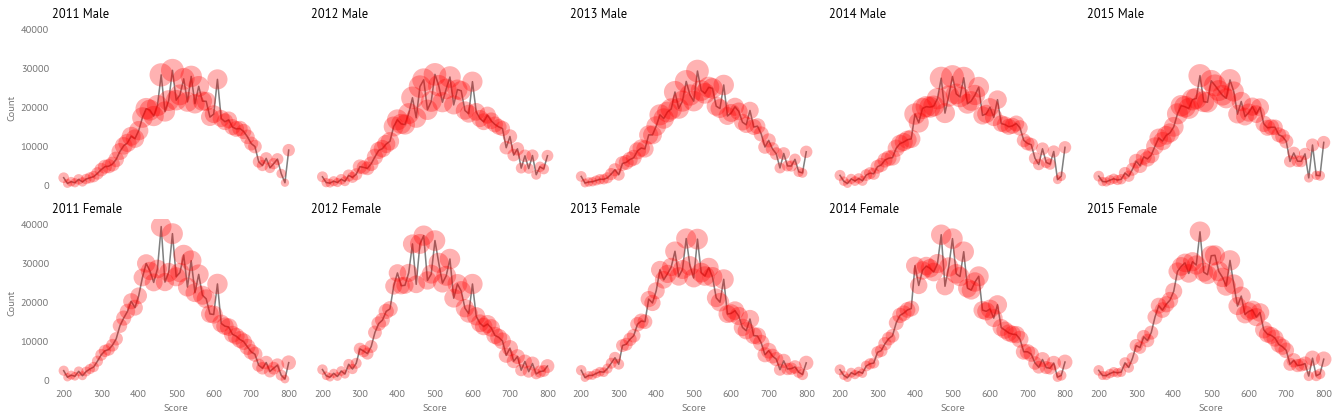

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18, 6), sharex=True, sharey=True)

for i, year in enumerate(years):
    for j, sex in enumerate(sexes):
        ax = axes[j, i]   # row = sex index, col = year index
        
        # Plot observed data
        data_series = df_map[year][sex]
        data_series.plot(ax=ax, color='gray', label=f'{year} {sex} data', linewidth=1.5)
        
        # Overlay influence markers
        # Note: sex indices are reversed in the influence arrays (j=0 is Female, j=1 is Male)
        # So we use 1-j to reverse the index
        sex_idx_reversed = 1 - j
        influence_vals = influence_3d[i, sex_idx_reversed, :]
        sizes = influence_sizes[i, sex_idx_reversed, :]
        pareto_vals = pareto_k_3d[i, sex_idx_reversed, :]
        
        # Ensure data is aligned with thetas (score bins)
        # Get counts in the same order as thetas
        counts_aligned = data_series.loc[thetas].values
        
        # Use color intensity based on Pareto-k values
        # High Pareto-k (> 0.7) = red, medium (0.5-0.7) = orange, low (< 0.5) = blue
        colors = np.where(
            pareto_vals > 0.7, 'red',
            np.where(pareto_vals > 0.5, 'orange', 'blue')
        )
        alpha = np.where(pareto_vals > 0.7, 0.3, np.where(pareto_vals > 0.5, 0.5, 0.3))
        
        ax.scatter(
            thetas, 
            counts_aligned,  # Use explicitly aligned counts
            s=sizes,
            c=colors,
            alpha=alpha,
            edgecolors='none',
            zorder=5
        )
        
        plt.sca(ax)
        decorate(title=f'{year} {sex}', legend=False, xlabel='Score', ylabel='Count')
        
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("selection_bias3_loo_influence.png", dpi=300)

## Summary Statistics

In [19]:
# Summary by year and sex
summary_data = []
for i, year in enumerate(years):
    for j, sex in enumerate(sexes):
        influence_vals = influence_3d[i, j, :]
        pareto_vals = pareto_k_3d[i, j, :]
        
        summary_data.append({
            'Year': year,
            'Sex': sex,
            'Mean Influence': influence_vals.mean(),
            'Max Influence': influence_vals.max(),
            'Mean Pareto-k': pareto_vals.mean(),
            'Max Pareto-k': pareto_vals.max(),
            'Problematic (k>0.7)': (pareto_vals > 0.7).sum(),
        })

summary_df = pd.DataFrame(summary_data)
summary_df

,Year,Sex,Mean Influence,Max Influence,Mean Pareto-k,Max Pareto-k,Problematic (k>0.7)
0,2011,Male,-48714.248613,-4209.010567,5.358670,5.358670,61
1,2011,Female,-54785.639374,-3666.887512,5.750314,5.750314,61
2,2012,Male,-49300.269000,-4781.146872,6.570782,6.570782,61
3,2012,Female,-55466.455489,-6366.388303,6.692115,6.692115,61
4,2013,Male,-49325.387104,-4916.678759,6.182233,6.182233,61
5,2013,Female,-55455.308152,-5741.796364,6.845833,6.845833,61
6,2014,Male,-49929.709959,-4008.064290,6.203646,6.203646,61
7,2014,Female,-55792.829201,-5595.080456,6.973172,6.973172,61
8,2015,Male,-50684.533090,-6714.456797,6.783389,6.783389,61
9,2015,Female,-56839.843291,-8305.694716,6.245236,6.245236,61


In [17]:
# Find the most influential score bins overall
flat_influence = influence_3d.flatten()
flat_pareto_k = pareto_k_3d.flatten()

# Get indices of top 10 most influential
top_indices = np.argsort(np.abs(flat_influence))[-10:][::-1]

print("Top 10 most influential observations:")
for idx in top_indices:
    # Convert flat index back to (year, sex, score) coordinates
    year_idx, sex_idx, score_idx = np.unravel_index(idx, influence_3d.shape)
    year = years[year_idx]
    sex = sexes[sex_idx]
    score = thetas[score_idx]
    influence = flat_influence[idx]
    pareto_k = flat_pareto_k[idx]
    print(f"  {year} {sex} Score {score}: influence={influence:.3f}, Pareto-k={pareto_k:.3f}")

Top 10 most influential observations:
  2011 Female Score 460: influence=-123109.637, Pareto-k=5.750
  2015 Female Score 470: influence=-121418.253, Pareto-k=6.245
  2014 Female Score 470: influence=-119193.197, Pareto-k=6.973
  2011 Female Score 490: influence=-118810.895, Pareto-k=5.750
  2012 Female Score 470: influence=-118521.423, Pareto-k=6.692
  2014 Female Score 500: influence=-117268.206, Pareto-k=6.973
  2013 Female Score 480: influence=-117149.876, Pareto-k=6.846
  2013 Female Score 510: influence=-116241.707, Pareto-k=6.846
  2012 Female Score 500: influence=-115484.776, Pareto-k=6.692
  2012 Female Score 440: influence=-114745.910, Pareto-k=6.692


## Interpretation

The influence scores show which score bins have the greatest impact on the model's predictions. High influence values indicate that removing that particular score bin would substantially change the model's predictions.

Pareto-k values indicate the reliability of the LOO approximation:
- Pareto-k < 0.5: Good approximation
- 0.5 ≤ Pareto-k < 0.7: OK approximation, but some caution needed
- Pareto-k ≥ 0.7: Problematic - the LOO approximation may be unreliable for these observations

The visualization uses:
- Marker size: Proportional to absolute influence score
- Marker color: Red for high Pareto-k (> 0.7), orange for medium (0.5-0.7), blue for low (< 0.5)
- Marker transparency: Higher opacity for more problematic observations
